# Global Food Delivery Pairs Trading Strategy
- Hargun Singh

**Markets:** DoorDash (US) vs Zomato (India)

**Strategy:** Currency-adjusted pairs trading between two food delivery companies in different countries.

**The Edge:** Both companies compete in the same business model globally - customer acquisition, driver retention, commission economics. When their valuations diverge (accounting for FX), mean reversion occurs.

**Background:** All my previous internships have been at Food Delivery companies, and I'm curious to see how correlated the company's performances are across borders. I wanted to use my company (Swiggy) as one of the options but they only IPO'ed recently so I couldn't get enough data to make a claim. I also considered using Uber as an example, but too much of their revenue comes from non-food sources for it to count.

## Imports

In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Download Data: DASH, ETERNAL (Zomato), USD/INR, SPY

In [35]:
# Download data (past 4 years for robust backtesting)
start_date = '2022-01-01'
end_date = '2026-02-01'

print("Downloading stock data...")
print("=" * 60)

# Download stocks and FX rate
dash = yf.download('DASH', start=start_date, end=end_date, progress=False)
eternal = yf.download('ETERNAL.NS', start=start_date, end=end_date, progress=False)
usdinr = yf.download('USDINR=X', start=start_date, end=end_date, progress=False)
spy = yf.download('SPY', start=start_date, end=end_date, progress=False)

print(f"✓ DASH: {len(dash)} rows")
print(f"✓ ETERNAL (Zomato): {len(eternal)} rows")
print(f"✓ USD/INR: {len(usdinr)} rows")
print(f"✓ SPY: {len(spy)} rows")

# Create dataframe with DASH (already in USD)
df = pd.DataFrame(index=dash.index)
df['DASH'] = dash['Close'].squeeze()
df['SPY'] = spy['Close'].squeeze()

# Align ETERNAL and FX data to DASH dates
df['ETERNAL_INR'] = eternal['Close'].squeeze().reindex(df.index).ffill()
df['USDINR'] = usdinr['Close'].squeeze().reindex(df.index).ffill()

# Convert ETERNAL from INR to USD
df['ETERNAL_USD'] = df['ETERNAL_INR'] / df['USDINR']

# Remove any NaN values
df = df.dropna()

print(f"\n✓ Combined: {len(df)} trading days")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nStarting prices (USD):")
print(f"  DASH:          ${df['DASH'].iloc[0]:.2f}")
print(f"  ETERNAL (adj): ${df['ETERNAL_USD'].iloc[0]:.2f}")
print(f"  SPY:           ${df['SPY'].iloc[0]:.2f}")
print(f"\nLatest prices (USD):")
print(f"  DASH:          ${df['DASH'].iloc[-1]:.2f}")
print(f"  ETERNAL (adj): ${df['ETERNAL_USD'].iloc[-1]:.2f}")
print(f"  Exchange rate: {df['USDINR'].iloc[-1]:.2f} INR/USD")

df.head()

✓ DASH: 1023 rows
✓ ETERNAL (Zomato): 987 rows
✓ USD/INR: 1060 rows
✓ SPY: 1023 rows

✓ Combined: 1023 trading days
Date range: 2022-01-03 to 2026-01-30

Starting prices (USD):
  DASH:          $145.34
  ETERNAL (adj): $1.90
  SPY:           $451.88

Latest prices (USD):
  DASH:          $204.62
  ETERNAL (adj): $2.98
  Exchange rate: 91.78 INR/USD


,DASH,SPY,ETERNAL_INR,USDINR,ETERNAL_USD
Date,,,,,
2022-01-03,145.339996,451.875092,141.350006,74.513802,1.896964
2022-01-04,135.910004,451.723785,138.350006,74.403297,1.859461
2022-01-05,127.970001,443.049744,133.949997,74.534897,1.797145
2022-01-06,137.279999,442.633545,130.000000,74.430099,1.746605
2022-01-07,132.270004,440.883575,129.250000,74.419296,1.736781


## Calculate Pairs Trading Indicators

In [36]:
# Calculate DASH/ETERNAL ratio and z-score
df['Ratio'] = df['DASH'] / df['ETERNAL_USD']
df['Ratio_MA'] = df['Ratio'].rolling(window=20).mean()
df['Ratio_Std'] = df['Ratio'].rolling(window=20).std()
df['Z_Score'] = (df['Ratio'] - df['Ratio_MA']) / df['Ratio_Std']

# Remove NaN rows from rolling calculations
df = df.dropna()

print("DASH/ETERNAL (USD-adjusted) Pairs Analysis:")
print(f"  Average ratio: {df['Ratio'].mean():.3f}")
print(f"  Z-Score range: [{df['Z_Score'].min():.2f}, {df['Z_Score'].max():.2f}]")
print(f"  Total trading days: {len(df)}")

df[['DASH', 'ETERNAL_USD', 'Ratio', 'Z_Score']].tail()

DASH/ETERNAL (USD-adjusted) Pairs Analysis:
  Average ratio: 71.153
  Z-Score range: [-3.79, 2.93]
  Total trading days: 1004


,DASH,ETERNAL_USD,Ratio,Z_Score
Date,,,,
2026-01-26,209.410004,2.827292,74.067351,1.035871
2026-01-27,207.360001,2.767871,74.916791,1.257806
2026-01-28,206.660004,2.909292,71.034472,0.265199
2026-01-29,207.679993,2.991608,69.420856,-0.111717
2026-01-30,204.619995,2.980980,68.641854,-0.272282


## 🎯 Generate Trading Signals

**Logic:**
- **Entry:** Z-Score < -1 (DASH undervalued vs ETERNAL → BUY DASH)
- **Exit:** Z-Score > 0.5 (ratio normalized → SELL)

In [37]:
# Generate trading signals
df['Signal'] = 0.0

# Entry: Buy DASH when it's underperforming UBER
df.loc[df['Z_Score'] < -1, 'Signal'] = 1.0

# Exit: Sell when ratio normalizes
df.loc[df['Z_Score'] > 0.5, 'Signal'] = 0.0

# Forward fill to maintain positions
df['Signal'] = df['Signal'].ffill()

# Calculate statistics
days_in_position = (df['Signal'] == 1).sum()
num_trades = (df['Signal'].diff() != 0).sum()

print("Trading Strategy Statistics:")
print(f"  Days in position: {days_in_position}/{len(df)} ({days_in_position/len(df)*100:.1f}%)")
print(f"  Number of trades: {num_trades}")
print(f"  Avg holding period: {days_in_position/max(num_trades/2, 1):.1f} days")

Trading Strategy Statistics:
  Days in position: 259/1004 (25.8%)
  Number of trades: 149
  Avg holding period: 3.5 days


## Calculate Returns & Performance

In [38]:
# Calculate daily returns
df['DASH_Returns'] = df['DASH'].pct_change()
df['ETERNAL_Returns'] = df['ETERNAL_USD'].pct_change()
df['SPY_Returns'] = df['SPY'].pct_change()

# Strategy returns (only when in position)
df['Strategy_Returns'] = df['Signal'].shift(1) * df['DASH_Returns']

# Cumulative returns
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod() - 1
df['DASH_BuyHold'] = (1 + df['DASH_Returns']).cumprod() - 1
df['ETERNAL_BuyHold'] = (1 + df['ETERNAL_Returns']).cumprod() - 1
df['SPY_BuyHold'] = (1 + df['SPY_Returns']).cumprod() - 1

# Remove first row (NaN from pct_change)
df = df.dropna()

# Calculate Sharpe Ratio (annualized)
strategy_sharpe = (df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()) * np.sqrt(252)
dash_sharpe = (df['DASH_Returns'].mean() / df['DASH_Returns'].std()) * np.sqrt(252)
eternal_sharpe = (df['ETERNAL_Returns'].mean() / df['ETERNAL_Returns'].std()) * np.sqrt(252)
spy_sharpe = (df['SPY_Returns'].mean() / df['SPY_Returns'].std()) * np.sqrt(252)

# Print results
strategy_return = df['Strategy_Cumulative'].iloc[-1] * 100
dash_return = df['DASH_BuyHold'].iloc[-1] * 100
eternal_return = df['ETERNAL_BuyHold'].iloc[-1] * 100
spy_return = df['SPY_BuyHold'].iloc[-1] * 100

print("\n" + "=" * 60)
print("PERFORMANCE RESULTS")
print("=" * 60)
print(f"\nPairs Strategy:        {strategy_return:>8.2f}%  (Sharpe: {strategy_sharpe:.2f})")
print(f"DASH Buy & Hold:       {dash_return:>8.2f}%  (Sharpe: {dash_sharpe:.2f})")
print(f"ETERNAL Buy & Hold:    {eternal_return:>8.2f}%  (Sharpe: {eternal_sharpe:.2f})")
print(f"SPY Benchmark:         {spy_return:>8.2f}%  (Sharpe: {spy_sharpe:.2f})")
print(f"\nOutperformance vs SPY: {strategy_return - spy_return:>+8.2f}%")
print("=" * 60)


PERFORMANCE RESULTS

Pairs Strategy:           64.14%  (Sharpe: 0.60)
DASH Buy & Hold:          80.30%  (Sharpe: 0.55)
ETERNAL Buy & Hold:      147.44%  (Sharpe: 0.71)
SPY Benchmark:            62.60%  (Sharpe: 0.77)

Outperformance vs SPY:    +1.55%


## Visualizations

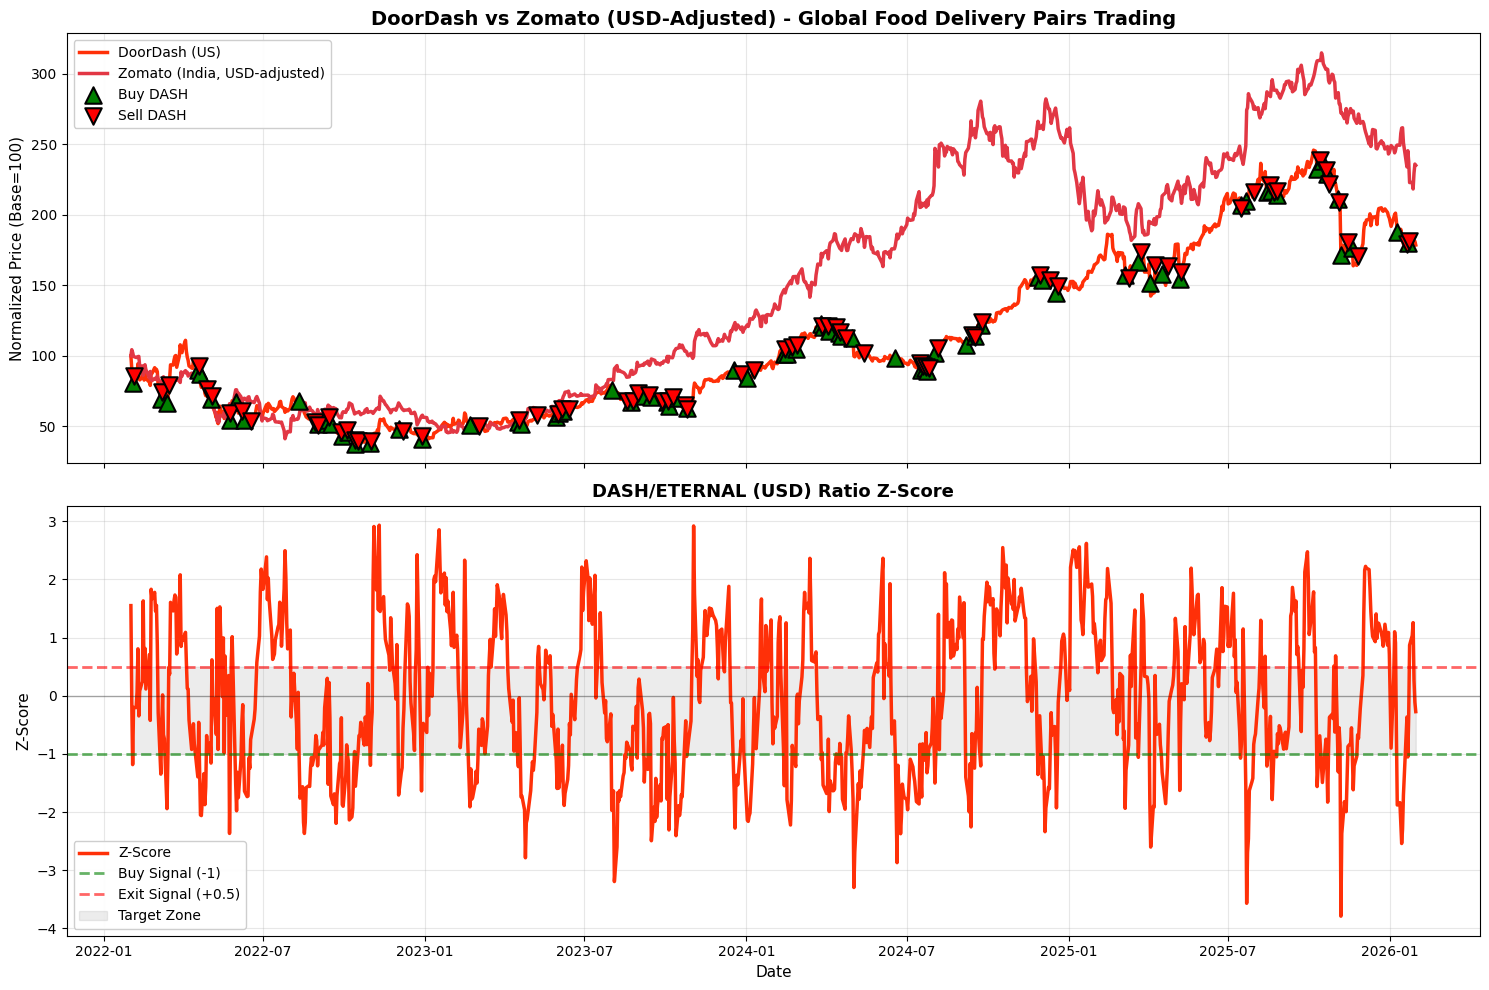

In [39]:
# PLOT 1: Stock Prices with Trading Signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Normalize prices to 100 at start
dash_norm = (df['DASH'] / df['DASH'].iloc[0]) * 100
eternal_norm = (df['ETERNAL_USD'] / df['ETERNAL_USD'].iloc[0]) * 100

# Top panel: Stock prices with trade signals
ax1.plot(df.index, dash_norm, label='DoorDash (US)', linewidth=2.5, color='#FF3008')
ax1.plot(df.index, eternal_norm, label='Zomato (India, USD-adjusted)', linewidth=2.5, color='#E23744')

# Mark buy/sell signals
buys = df[df['Signal'].diff() == 1]
sells = df[df['Signal'].diff() == -1]

if len(buys) > 0:
    ax1.scatter(buys.index, (df.loc[buys.index, 'DASH'] / df['DASH'].iloc[0]) * 100,
               marker='^', color='green', s=140, label='Buy DASH', zorder=5, edgecolors='black', linewidths=1.5)

if len(sells) > 0:
    ax1.scatter(sells.index, (df.loc[sells.index, 'DASH'] / df['DASH'].iloc[0]) * 100,
               marker='v', color='red', s=140, label='Sell DASH', zorder=5, edgecolors='black', linewidths=1.5)

ax1.set_ylabel('Normalized Price (Base=100)', fontsize=11)
ax1.set_title('DoorDash vs Zomato (USD-Adjusted) - Global Food Delivery Pairs Trading', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', framealpha=0.95, fontsize=10)
ax1.grid(True, alpha=0.3)

# Bottom panel: Z-Score
ax2.plot(df.index, df['Z_Score'], color='#FF3008', linewidth=2.5, label='Z-Score')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
ax2.axhline(y=-1, color='green', linestyle='--', alpha=0.6, linewidth=2, label='Buy Signal (-1)')
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Exit Signal (+0.5)')
ax2.fill_between(df.index, -1, 0.5, alpha=0.15, color='gray', label='Target Zone')

ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Z-Score', fontsize=11)
ax2.set_title('DASH/ETERNAL (USD) Ratio Z-Score', fontsize=13, fontweight='bold')
ax2.legend(loc='best', framealpha=0.95, fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

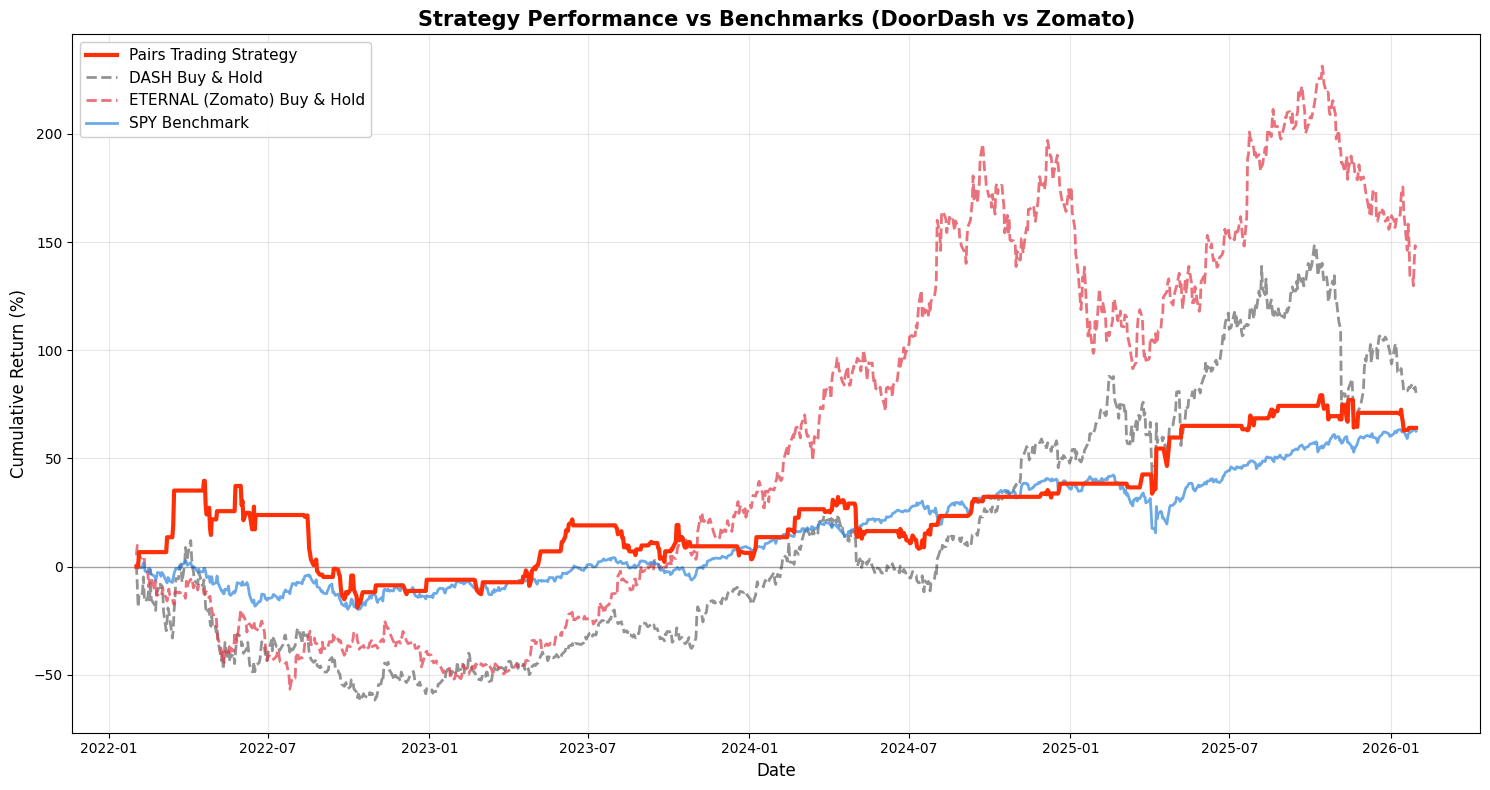


✅ Analysis complete!


In [40]:
# PLOT 2: Cumulative Returns Comparison
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))

# Plot all strategies
ax.plot(df.index, df['Strategy_Cumulative'] * 100, 
        label='Pairs Trading Strategy', linewidth=3, color='#FF3008', zorder=4)
ax.plot(df.index, df['DASH_BuyHold'] * 100, 
        label='DASH Buy & Hold', linewidth=2, linestyle='--', alpha=0.7, color='#666666')
ax.plot(df.index, df['ETERNAL_BuyHold'] * 100, 
        label='ETERNAL (Zomato) Buy & Hold', linewidth=2, linestyle='--', alpha=0.7, color='#E23744')
ax.plot(df.index, df['SPY_BuyHold'] * 100, 
        label='SPY Benchmark', linewidth=2, alpha=0.7, color='#2E86DE')

# Add zero line
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

# Labels and formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.set_title('Strategy Performance vs Benchmarks (DoorDash vs Zomato)', 
             fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Analysis complete!")